In [33]:
from PIL import Image
import os
from torch.utils.data import Dataset,DataLoader
import json
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [34]:
img_path='../CustomPoseEstimatorData/images'
label_path='../CustomPoseEstimatorData/labels.json'

In [122]:
class PoseDataset(Dataset):
    def __init__(self,img_path,label_path,img_size,heatmap_size,sigma):
        super().__init__()

        self.img_size=img_size
        self.heatmap_size=heatmap_size
        self.sigma=sigma
        
        self.images=[os.path.join(img_path,img) for img in os.listdir(img_path)]
        with open(label_path,'r') as file_option:
            self.labels=json.load(file_option)

        self.trans=transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.images)

    def generate_heatmaps(self,joints):
        stride=self.img_size/self.heatmap_size
        h,w=self.heatmap_size,self.heatmap_size
        heatmaps=np.zeros((len(joints),h,w))
        
        for i,joint in enumerate(joints):
            x,y,visibility=joint
            if visibility==0:
                continue
            mu_x=x/stride
            mu_y=y/stride
    
            x_range,y_range=np.arange(0,self.heatmap_size,1),np.arange(0,self.heatmap_size,1)
            xx,yy=np.meshgrid(x_range,y_range)#инвертированно
    
            d2=(xx-mu_x)**2+(yy-mu_y)**2
            exponent=d2/(2*self.sigma**2)
            heatmap=np.exp(-exponent)
    
            heatmaps[i]=heatmap
        return torch.from_numpy(heatmaps)


    def __getitem__(self,idx):
        img=Image.open(self.images[idx])
        orig_w,orig_h=img.size
        tensor_img=self.trans(img)
        
        label=self.labels[idx]

        joints=np.array(label['joint_self'])
        joints[:,0]=joints[:,0]*(self.img_size/orig_w)
        joints[:,1]=joints[:,1]*(self.img_size/orig_h)

        target=self.generate_heatmaps(joints=joints)

        
        return {
            'img':tensor_img,
            'label':target
        }

In [123]:
pose_data=PoseDataset(img_path=img_path,label_path=label_path,img_size=224,heatmap_size=56,sigma=2)

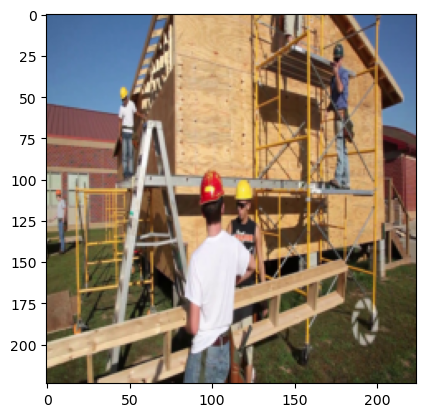

In [124]:
plt.imshow(pose_data[0]['img'].permute(1,2,0).detach())

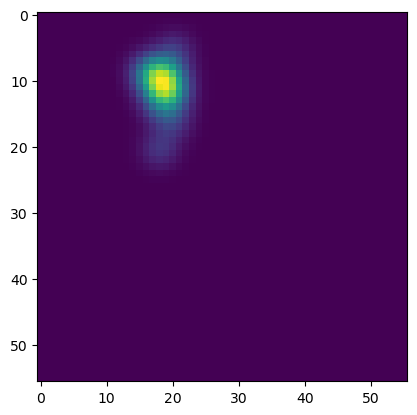

In [125]:
plt.imshow(pose_data[0]['label'].sum(axis=0))

In [ ]:
img_size=224
heatmap_size=56
sigma=1.5

In [11]:
def generate_heatmaps(self,joints):
    stride=img_size/heatmap_size
    h,w=heatmap_size,heatmap_size
    heatmaps=np.zeros((len(joints),h,w))
    

    for i,joint in enumerate(joints):
        x,y,visibility=joint
        if visibility==0:
            continue
        mu_x=x/stride
        mu_y=y/stride

        x_range,y_range=np.arange(0,heatmap_size,1),np.arange(0,heatmap_size,1)
        yy,xx=np.meshgrid(y_range,x_range)

        d2=(xx-mu_x)**2+(yy-mu_y)**2
        exponent=d2/(2*sigma**2)
        heatmap=np.exp(-exponent)

        heatmaps[i]=heatmap
    return torch.from_numpy(heatmaps)
        